In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import pygris

pd.set_option('display.max_rows', None)

In [19]:
data_path = os.path.expanduser("~/Downloads/tl_2021_us_state.zip")
states = gpd.read_file(data_path)

In [20]:
states_in_question = [
    'New York',
    'New Jersey',
    'Delaware',
    'Maryland',
    'Pennsylvania',
    'District of Columbia',
    'Virginia'
]

mid_atlantic = (
    states
    .loc[states['NAME'].isin(states_in_question), ['NAME', 'geometry']]
    .assign(idx=1)
    .dissolve(by='idx')
)


In [21]:
philly = Point(-75.1652, 39.9526)
pitt = Point(-79.9959, 40.4406)
baltimore = Point(-76.6122, 39.2904)
richmond = Point(-77.4360, 37.5407)
dc = Point(-77.0369, 38.9072)

mid_atlantic_geoms = [philly, pitt, baltimore, richmond, dc]

mid_atlantic_cities = (
    gpd.GeoDataFrame(
        {
            'city': [
                'Philadelphia', 
                'Pittsburgh',
                'Baltimore',
                'Richmond, VA',
                'Washington D.C.'
                ],
            'label': [
                'A', 
                'B', 
                'C', 
                'D', 
                'E'
                ]}, 
        geometry=mid_atlantic_geoms
    )
    .assign(answer=lambda df_: df_['label'] + ': ' + df_['city'])
)

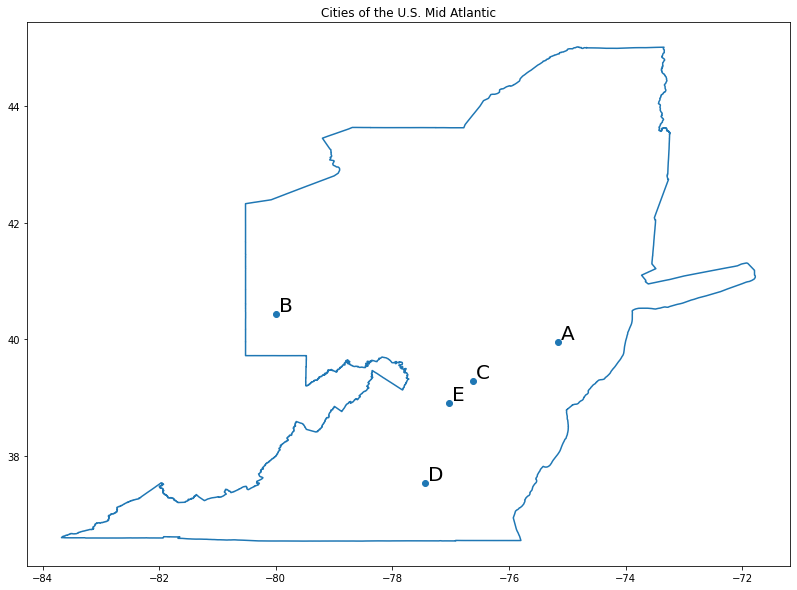

In [23]:
ax = mid_atlantic.boundary.plot(figsize=(14, 10))
mid_atlantic_cities.plot(ax=ax)

for x, y, label in zip(mid_atlantic_cities.geometry.x, mid_atlantic_cities.geometry.y, mid_atlantic_cities.label):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=20)

plt.title("Cities of the U.S. Mid Atlantic")
plt.show()

In [62]:
# df = pd.read_csv("/home/buchmayne/Downloads/ACSDP1Y2021.DP03-Data.csv", skiprows=1)


# keep = [
#     'Geographic Area Name',
#     'Estimate!!COMMUTING TO WORK!!Workers 16 years and over',
#     'Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Worked from home'
# ]

# cities = [
#     'Portland',
#     'Seattle',
#     'Los Angeles',
#     'San Francsico',
#     'Austin',
#     'Houston',
#     'Denver',
#     'Miami',
#     'Boston',
#     'Chicago'
# ]

# (
#     df
#     [keep]
#     .rename(columns={
#         'Geographic Area Name': 'geography',
#         'Estimate!!COMMUTING TO WORK!!Workers 16 years and over': 'workers',
#         'Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Worked from home': 'wfh'
#     })
#     .assign(
#         workers=lambda df_: pd.to_numeric(df_['workers'], errors='coerce'),
#         wfh=lambda df_: pd.to_numeric(df_['wfh'], errors='coerce')
#     )
#     .dropna()
#     .assign(pct_wfh=lambda df_: df_['wfh'] / df_['workers'])
#     [['geography', 'pct_wfh']]
#     .pipe(lambda df_:
#          pd.concat([df_, df_['geography'].str.split(',', expand=True)], axis=1)
#          )
#     .rename(columns={0: 'city', 1: 'state'})
#     .reset_index(drop=True)
#     .assign(state=lambda df_: df_['state'].str.strip())
#     .sort_values('pct_wfh', ascending=False)
#     .drop_duplicates()
#     .assign(city=lambda df_: df_['city'].str.replace(' city$', '', regex=True))
#     .loc[lambda df_: df_['city'].isin(cities)]
    
# )

,geography,pct_wfh,city,state
575,"Seattle city, Washington",0.468086,Seattle,Washington
492,"Austin city, Texas",0.387754,Austin,Texas
1058,"Portland city, Oregon",0.348797,Portland,Oregon
180,"Denver city, Colorado",0.322881,Denver,Colorado
926,"Boston city, Massachusetts",0.303146,Boston,Massachusetts
317,"Portland city, Maine",0.272261,Portland,Maine
270,"Chicago city, Illinois",0.270825,Chicago,Illinois
690,"Los Angeles city, California",0.238258,Los Angeles,California
227,"Miami city, Florida",0.183542,Miami,Florida
1108,"Houston city, Texas",0.156454,Houston,Texas


In [17]:
homeless_path = "/home/buchmayne/Downloads/2007-2022-PIT-Counts-by-State.xlsx"

homeless = (
    pd.read_excel(homeless_path, sheet_name="2022")
    [['State', 'Overall Homeless, 2022']]
    .rename(columns={
        'State': 'state', 'Overall Homeless, 2022': 'total_homeless_pop_2022'
    })
    .loc[lambda df_: ~df_['state'].isin(['AS', 'VI', 'PR', 'MP', 'GU'])]
)

In [33]:
total_pop_path = "/home/buchmayne/Downloads/NST-EST2022-POP.xlsx"

total_pop = (
    pd.read_excel(total_pop_path)
    [['table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts)', "Unnamed: 4"]]
    .rename(columns={
        'table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts)': "state", "Unnamed: 4": "total_pop_2022"
    })
    .iloc[3:]
    .dropna()
    .loc[lambda df_: ~df_['state'].isin(['Northeast', 'Midwest', 'South', 'West', '.Puerto Rico'])]
)

In [37]:
total_pop_fixed = (
    pd.concat([
        total_pop.loc[total_pop['state'] != 'United States'],
        total_pop.loc[total_pop['state'] == 'United States']
        ], axis=0)
    .rename(columns={'state': "state_"})
)

In [51]:
totals = (
    pd.concat([homeless.reset_index(drop=True), total_pop_fixed.reset_index(drop=True)], axis=1)
    .loc[51, :]
    )

In [47]:
crosswalk = (
    pygris
    .fips_codes()
    [['state', 'state_name']]
    .drop_duplicates()
    .reset_index(drop=True)
    .iloc[:51]
    )

In [72]:
(
    total_pop_fixed.reset_index(drop=True)
    .iloc[:51]
    .assign(state_name=lambda df_: df_['state_'].str[1:])
    .drop('state_', axis=1)
    .merge(crosswalk)
    .merge(homeless)
    .drop('state', axis=1)
    .assign(
        pct_pop=lambda df_: df_['total_pop_2022'] / totals.loc['total_pop_2022'],
        pct_homeless=lambda df_: df_['total_homeless_pop_2022'] / totals.loc['total_homeless_pop_2022']
    )
    .sort_values('pct_homeless', ascending=False)
    [['state_name', 'total_pop_2022', 'total_homeless_pop_2022', 'pct_pop', 'pct_homeless']]
)

,state_name,total_pop_2022,total_homeless_pop_2022,pct_pop,pct_homeless
4,California,39029342.0,171521,0.117104,0.294476
32,New York,19677151.0,74178,0.059040,0.127353
9,Florida,22244823.0,25959,0.066744,0.044568
47,Washington,7785786.0,25211,0.023361,0.043284
43,Texas,30029572.0,24432,0.090101,0.041946
37,Oregon,4240137.0,17959,0.012722,0.030833
21,Massachusetts,6981974.0,15507,0.020949,0.026623
2,Arizona,7359197.0,13553,0.022081,0.023268
38,Pennsylvania,12972008.0,12691,0.038921,0.021789
10,Georgia,10912876.0,10689,0.032743,0.018351
